In [2]:
!pip install natsort

  Obtaining dependency information for natsort from https://files.pythonhosted.org/packages/ef/82/7a9d0550484a62c6da82858ee9419f3dd1ccc9aa1c26a1e43da3ecd20b0d/natsort-8.4.0-py3-none-any.whl.metadata


In [1]:
import os
import cv2
import random
import itertools
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted
from os import makedirs, listdir
from os.path import join, exists, isdir
from PIL import Image, ImageChops, ImageEnhance

import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.applications import (MobileNetV2, Xception, InceptionV3, EfficientNetB7, ResNet101, NASNetLarge,
                                           VGG19, VGG16, DenseNet201)
from tensorflow.keras.applications import (mobilenet_v2, xception, inception_v3, efficientnet, resnet, nasnet, vgg19,
                                           vgg16, densenet)

np.random.seed(2)
plt.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
class Config:
    CASIA1 = "C:/Users/Najmi/Downloads/Datasets/CASIA2"
    CASIA2 = "CASIA2"
    autotune = tf.data.experimental.AUTOTUNE
    epochs = 30
    batch_size = 32
    lr = 1e-3
    name = 'xception'
    n_labels = 2
    image_size = (224, 224)
    decay = 1e-6
    momentum = 0.95
    nesterov = False

In [3]:
# Dictionary having models and their preprocess

models = {
    'densenet': DenseNet201,
    'xception': Xception,
    'inceptionv3': InceptionV3,
    'effecientnetb7': EfficientNetB7,
    'vgg19': VGG19,
    'vgg16': VGG16,
    'nasnetlarge': NASNetLarge,
    'mobilenetv2': MobileNetV2,
    'resnet': ResNet101
}
# To use => myNet = models['densenet']()

preprocess = {
    'densenet': densenet.preprocess_input,
    'xception': xception.preprocess_input,
    'inceptionv3': inception_v3.preprocess_input,
    'effecientnetb7': efficientnet.preprocess_input,
    'vgg19': vgg19.preprocess_input,
    'vgg16': vgg16.preprocess_input,
    'nasnetlarge': nasnet.preprocess_input,
    'mobilenetv2': mobilenet_v2.preprocess_input,
    'resnet': resnet.preprocess_input
}

In [4]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # reading the  compressed image
    compressed_img = cv2.imread(temp_filename)

    # getting absolute difference between img1 and img2 and multiplying it by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff

In [5]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [6]:
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

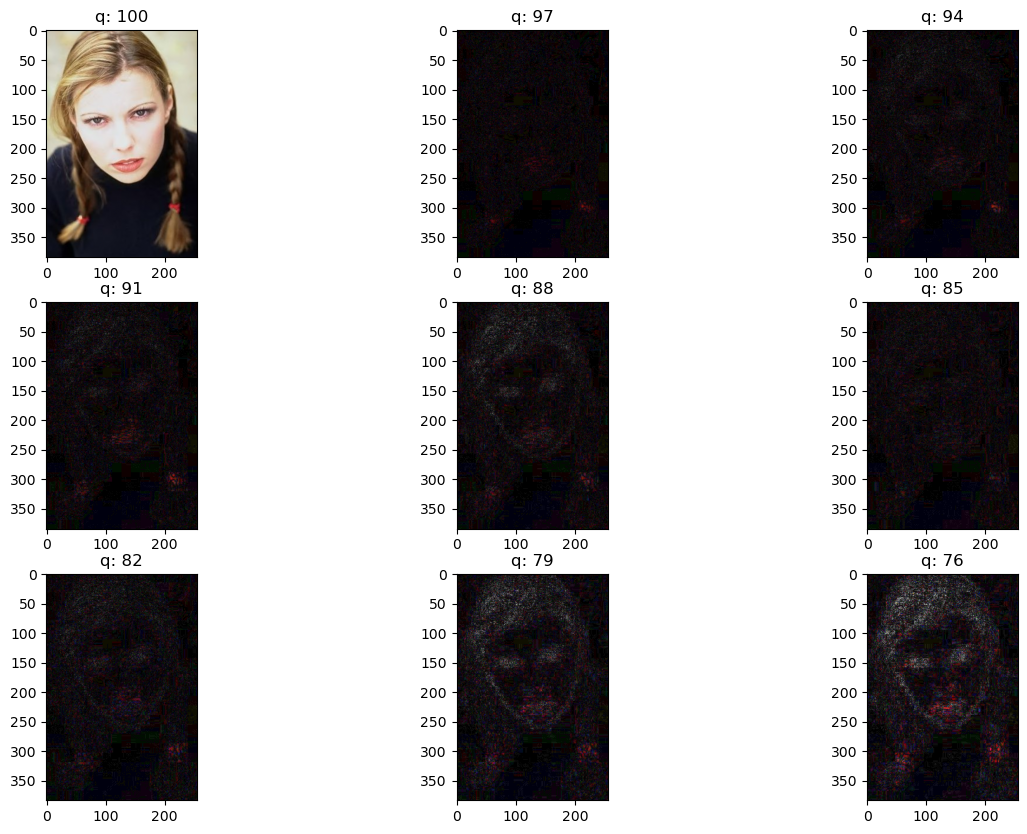

In [7]:
p = join(Config.CASIA2, 'C:/Users/Najmi/Downloads/Datasets/CASIA2/Au/')
p = random_sample(p)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

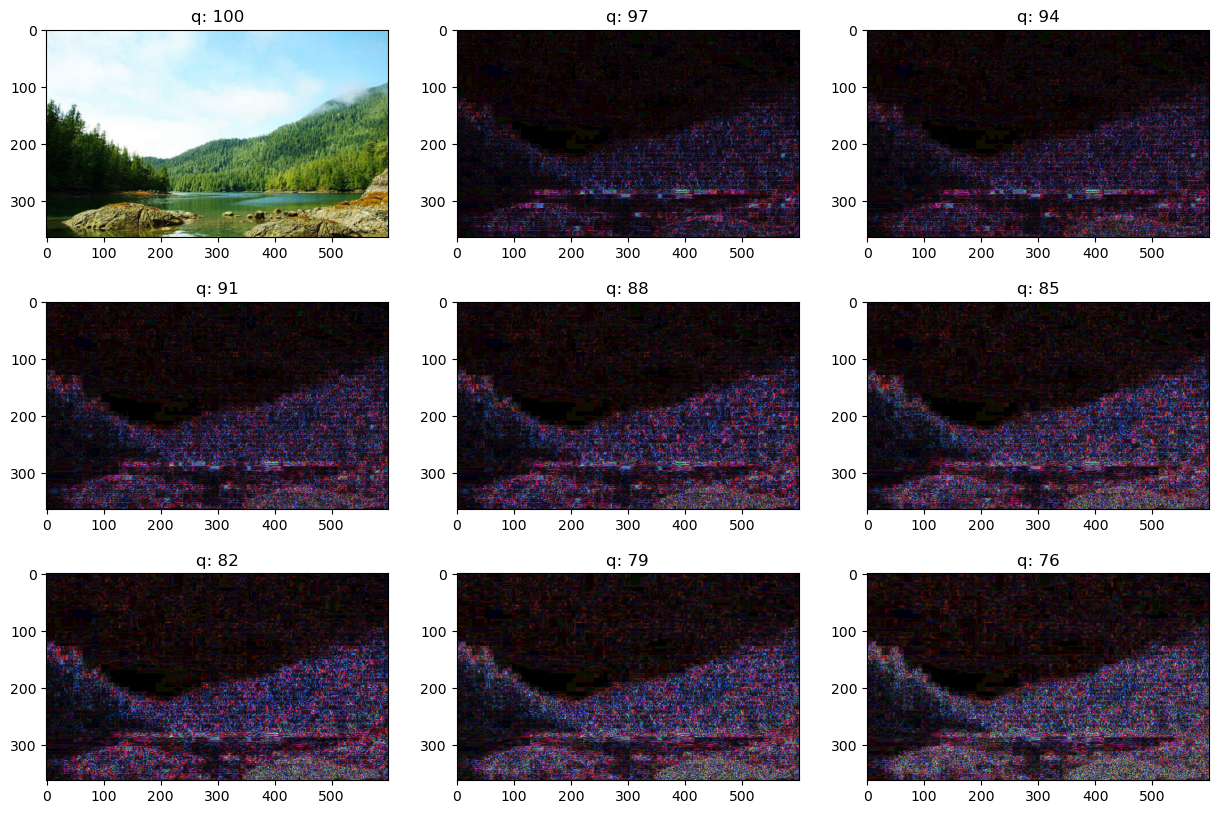

In [8]:
p = join(Config.CASIA1, 'C:/Users/Najmi/Downloads/Datasets/CASIA2/Tp/')
p = random_sample(p)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [34]:
!pip install albumentations --user

  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/a7/69/8674dad61e7851c858c167a8d6c32ccba1a32b2bf9a373c6e52b459a6e37/albumentations-1.4.0-py3-none-any.whl.metadata
  Using cached albumentations-1.4.0-py3-none-any.whl.metadata (35 kB)
  Obtaining dependency information for scikit-image>=0.21.0 from https://files.pythonhosted.org/packages/ce/d0/a3f60c9f57ed295b3076e4acdb29a37bbd8823452562ab2ad51b03d6f377/scikit_image-0.22.0-cp311-cp311-win_amd64.whl.metadata
  Using cached scikit_image-0.22.0-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Obtaining dependency information for opencv-python>=4.9.0 from https://files.pythonhosted.org/packages/c7/ec/9dabb6a9abfdebb3c45b0cc52dec901caafef2b2c7e7d6a839ed86d81e91/opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Obtaining dependency information for opencv-pytho

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [9]:
import albumentations as A
from albumentations import OneOf, Compose

@tf.function
def tensor_aug(img):
    img = tf.image.random_flip_left_right(img, 5)
    img = tf.image.random_flip_up_down(img, 5)
    return img

@tf.function
def batch_aug(images, labels):
    images = tf.map_fn(lambda img: tensor_aug(img), images)
    return images, labels


def ela_process(file_path):
    QUALITY = 95
    SCALE = 15
    LABELS = np.array(['Au', 'Tp'])

    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == LABELS
    # Integer encode the label
    label = tf.argmax(one_hot)
    label = tf.cast(label, tf.float32)

    # Generate the image
    orig = cv2.imread(file_path.numpy().decode('utf-8'))
    orig = cv2.resize(orig, (224, 224), interpolation = cv2.INTER_AREA)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    # Augmentation
    #
    buffer = cv2.imencode(".jpg", orig, [cv2.IMWRITE_JPEG_QUALITY, QUALITY])
    # get it from the buffer and decode it to a numpy array
    compressed_img = cv2.imdecode(np.frombuffer(buffer[1], np.uint8), cv2.IMREAD_COLOR)

    # Compute the absolute difference
    diff = SCALE * (cv2.absdiff(orig, compressed_img))
    img = preprocess[Config.name](diff)

    return img, label

jpg_pattern = 'C:/Users/Najmi/Downloads/Datasets/CASIA2/*/*jp*g'
tif_pattern = 'C:/Users/Najmi/Downloads/Datasets/CASIA2/*/*tif'

jpg_files = tf.data.Dataset.list_files(jpg_pattern)
tif_files = tf.data.Dataset.list_files(tif_pattern)

data_ds = jpg_files.concatenate(tif_files)

tensor_preprocess = lambda x: tf.py_function(ela_process, [x], [tf.float32, tf.float32])

n_data = data_ds.cardinality().numpy()
n_val = int(.2 * n_data)
data_ds = data_ds.shuffle(n_data)

train_ds = data_ds.skip(n_val).map(
    tensor_preprocess, num_parallel_calls=Config.autotune).batch(Config.batch_size).map(
    batch_aug, num_parallel_calls=Config.autotune)

val_ds = data_ds.take(n_val).map(
    tensor_preprocess, num_parallel_calls=Config.autotune).batch(Config.batch_size)

for img, label in train_ds:
    print(label)
    break

tf.Tensor(
[1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 0. 1.], shape=(32,), dtype=float32)


In [10]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def create_model(optimizer, name='mobilenet', loss='categorical_crossentropy'):
    """
    Creates a model based on the input name and freezes `blocks_to_train` blocks.
    Args:
        optimizer(tf.keras.optimizers): initialized tensorflow optimizers.
        name(str): one of the keys in the `models` list.
        blocks_to_train: name of the blocks to freeze. If not given, all the
        layers will be trainable.
        Loss: sets loss

    """

    base_model = models[name](include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    # model = Model(base_model.inputs, base_model.layers[-1].output)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(base_model.inputs, output)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=METRICS)
    return model

def scheduler(epoch):
    if epoch % 25 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.9)

    return K.get_value(model.optimizer.lr)

def generate_path(path_to_output, last_run=False):
    """
    Creates a new path and returns the address.
    Notes:
        Sometimes accidently, it happens that you overwrite your previous models. so
        this function is designed to create a new path for each run.
    """
    if not isdir(path_to_output):
        makedirs(path_to_output)

    runs = natsorted([path for path in listdir(path_to_output) if path.startswith("run_tf_data")])
    if last_run:
        if not bool(runs):
            path = join(path_to_output, "run_tf_data_1")
        else:
            path = join(path_to_output, runs[-1])

        return path
    if not bool(runs):
        path = join(path_to_output, 'run_tf_data_1')
    else:
        f = runs[-1].rsplit("data_")[1]
        path = join(path_to_output, 'run_tf_data_' + str(int(f) + 1))

    return path

In [11]:
loss=tf.keras.losses.BinaryCrossentropy()
optimizer = SGD(lr=Config.lr,
#                 decay=Config.decay,
                momentum=Config.momentum,
                nesterov=Config.nesterov)
"""
Model             Params
mobilenet           3M
effecientnetb7      66M
nasnetlarge         89M
inceptionv3         23M
xception            22M
resnet              44M
densenet            20M

"""


model = create_model(optimizer, name=Config.name, loss=loss)

# model.summary()

83683744/83683744 [==============================] - 23s 0us/step


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

                                                                                                  
 block4_sepconv2_act (Activ  (None, 28, 28, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 28, 28, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 28, 28, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 14, 14, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 14, 14, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 14, 14, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 14, 14, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 14, 14, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 14, 14, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 14, 14, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 14, 14, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 14, 14, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 14, 14, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

In [ ]:
path = generate_path('checkpoints')
weight_path = join(path, 'weights')
tensorboard_path = join(path, 'logs')

makedirs(weight_path)
makedirs(tensorboard_path)

ckpt = ModelCheckpoint(
    filepath=weight_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

tensorboard = TensorBoard(
    log_dir=tensorboard_path,
    write_graph=True
)

reduce_lr = LearningRateScheduler(scheduler)


callbacks = [ckpt,
#              reduce_lr,
             tensorboard]

history = model.fit(
    train_ds,
    epochs=6,
    batch_size=Config.batch_size,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/6
 10/314 [..............................] - ETA: 2:07:37 - loss: 0.6773 - accuracy: 0.0000e+00 - precision: 0.4828 - recall: 0.1045 - auc: 0.5368 - prc: 0.4382